In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

import Cdf

In [2]:
params = {'axes.labelsize' : 14, 'axes.titlesize' : 14,
          'font.size' : 14, 'legend.fontsize' : 14,
          'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.rcParams.update(params)

In [3]:
conn = sqlite3.connect('../data/netflix-data-aggregated.db')
traceroute = pd.read_sql_query('select * from traceroute',
                               con=conn, parse_dates=['dtime'])
conn.close()

In [4]:
traceroute

,unit_id,dtime,destination_v4,ttl_v4,rtt_v4,destination_v6,ttl_v6,rtt_v6,delta_ttl,delta_rtt
0,123256,2016-07-22 00:00:00,198.38.119.140,8,16.989,2a00:86c0:119:119::145,9,14.370,-1,2.619
1,123256,2016-07-22 02:00:00,198.38.118.140,8,16.136,2a00:86c0:119:119::142,9,15.826,-1,0.310
2,123256,2016-07-22 04:00:00,198.38.119.149,8,22.194,2a00:86c0:116:116::145,11,20.654,-3,1.540
3,123256,2016-07-22 10:00:00,198.38.119.149,8,20.222,2a00:86c0:116:116::148,11,23.037,-3,-2.815
4,123256,2016-07-22 13:00:00,198.38.117.153,10,23.100,2a00:86c0:118:118::143,9,17.366,1,5.734
...,...,...,...,...,...,...,...,...,...,...
894934,950234,2019-05-03 19:00:00,45.57.38.138,7,9.789,2a00:86c0:2039:2039::142,7,9.648,0,0.141
894935,950234,2019-05-03 20:00:00,45.57.38.144,7,9.947,2a00:86c0:2038:2038::141,6,9.825,1,0.122
894936,950234,2019-05-03 21:00:00,45.57.38.136,7,12.507,2a00:86c0:2038:2038::145,7,13.175,0,-0.668
894937,950234,2019-05-03 22:00:00,45.57.39.143,7,9.526,2a00:86c0:2038:2038::138,6,11.090,1,-1.564


In [5]:
traceroute['dtime'] = traceroute['dtime'].dt.floor('D')

In [6]:
df = traceroute.groupby(['unit_id', 'dtime'], as_index=False
                       ).agg({'delta_ttl' : 'median'}
                            )
df

,unit_id,dtime,delta_ttl
0,62712,2017-01-31,-2.0
1,62712,2017-02-01,-1.0
2,62712,2017-02-02,-1.0
3,62712,2017-02-03,-1.0
4,62712,2017-02-04,-1.0
...,...,...,...
45465,950240,2017-08-08,0.0
45466,950240,2017-08-09,0.0
45467,950240,2017-08-10,0.0
45468,950240,2017-08-11,0.0


In [7]:
df['year'] = df['dtime'].dt.year
df['month'] = df['dtime'].dt.month

In [8]:
by_years = df.groupby('year')

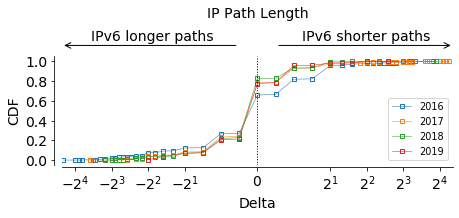

In [9]:
cdf_fig, cdf_ax = plt.subplots(figsize = (7, 2))

cdfs = []

for year, year_df in by_years:
    delta_ttl = Cdf.MakeCdfFromList(year_df['delta_ttl'])

    cdf_ax.plot(delta_ttl.xs, delta_ttl.ps, label = year, marker = 's',
                linewidth = 0.5, markersize = 3.5, fillstyle = 'none')

    cdfs.append((year, 'Path Length Deltas', delta_ttl))

cdf_ax.set_ylim([-0.05, 1.05])
cdf_ax.set_xlabel('Delta')
cdf_ax.set_ylabel('CDF')
cdf_ax.set_xlim([-20.5, 20.5])
cdf_ax.set_xscale('symlog', basex=2)

cdf_ax.legend(loc = 'lower right', fontsize = 'x-small')

yticks = np.arange(0.0, 1.01, 0.2)
cdf_ax.set_yticks(yticks)
cdf_ax.grid(False)
cdf_ax.spines['right'].set_color('none')
cdf_ax.spines['top'].set_color('none')
cdf_ax.yaxis.set_ticks_position('left')
cdf_ax.xaxis.set_ticks_position('bottom')
cdf_ax.spines['bottom'].set_position(('axes', -0.02))
cdf_ax.spines['left'].set_position(('axes', -0.02))

cdf_ax.set_title('IP Path Length', y=1.3)

cdf_ax.axvline(x=0.0, linewidth=1.0, color='black', ls = 'dotted')

cdf_ax.annotate('', xy = (0.45, 1.1), xycoords = 'axes fraction', xytext = (0, 1.1), 
            arrowprops = dict(arrowstyle = "<-"))
cdf_ax.annotate('', xy = (1, 1.1), xycoords = 'axes fraction', xytext = (0.55, 1.1), 
                    arrowprops = dict(arrowstyle="->"))

cdf_ax.text(0.075, 1.15, "IPv6 longer paths", transform=cdf_ax.transAxes)
cdf_ax.text(0.615, 1.15, "IPv6 shorter paths", transform=cdf_ax.transAxes)

cdf_fig.savefig('../plots/delta-ttl-by-year.pdf', bbox_inches = 'tight')
plt.show()

In [10]:
for year, version, cdf in cdfs:
    print(year, '\t\t', version)
    print('----------------')
    skip = max(1,int(len(cdf.xs)/150))
    for x, p in list(zip(cdf.xs, cdf.ps))[::skip]:
        print('%.2f\t\t%.5f' % (x, p))
    print('\n===========================\n')

2016 		 Path Length Deltas
----------------
-20.00		0.00013
-16.00		0.00027
-15.00		0.00053
-14.00		0.00067
-12.00		0.00307
-11.50		0.00320
-11.00		0.00426
-10.00		0.00813
-9.00		0.01279
-8.00		0.02305
-7.50		0.02332
-7.00		0.02985
-6.50		0.02998
-6.00		0.03531
-5.50		0.03571
-5.00		0.04104
-4.50		0.04278
-4.00		0.07356
-3.50		0.07409
-3.00		0.09128
-2.50		0.09342
-2.00		0.12287
-1.50		0.12433
-1.00		0.26639
-0.50		0.27119
0.00		0.65738
0.50		0.66538
1.00		0.81850
1.50		0.82183
2.00		0.95842
2.50		0.95949
3.00		0.97108
4.00		0.97721
4.50		0.97814
5.00		0.98201
5.50		0.98214
6.00		0.98361
6.50		0.98401
7.00		0.98481
8.00		0.98787
8.50		0.98814
9.00		0.99827
9.50		0.99880
10.00		0.99987
14.00		1.00000


2017 		 Path Length Deltas
----------------
-12.00		0.00015
-7.50		0.00020
-7.00		0.00076
-6.50		0.00081
-6.00		0.00126
-5.00		0.00972
-4.50		0.01017
-4.00		0.03857
-3.50		0.03897
-3.00		0.05091
-2.50		0.05116
-2.00		0.08102
-1.50		0.08444
-1.00		0.23369
-0.50		0.23857
0.00		0.78258
0.50	